In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from sklearn.manifold import TSNE


In [21]:
transactions_df = pd.read_csv("../02_data/transactions.csv")

X = transactions_df.drop(columns=["class"])
y = transactions_df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.75, random_state=42)

#scale (optional but try later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (50942, 167)
Test set shape: (152827, 167)


In [22]:
iso_forest = IsolationForest(contamination=.1, max_samples=256, n_estimators=100, random_state=42)
iso_forest.fit(X_train_scaled)



,n_estimators,100
,max_samples,256
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [23]:
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

decision_scores_train = iso_forest.decision_function(X_train_scaled)
decision_scores_test = iso_forest.decision_function(X_test_scaled)
print(f"  Normal: {(y_pred_test == 1).sum()} ({(y_pred_test == 1).sum()/len(y_pred_test)*100:.1f}%)")
print(f"  Anomalies: {(y_pred_test == -1).sum()} ({(y_pred_test == -1).sum()/len(y_pred_test)*100:.1f}%)")

/Users/jgupta/Downloads/GitTracking/bitcoin-fraud/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/Users/jgupta/Downloads/GitTracking/bitcoin-fraud/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


  Normal: 134369 (87.9%)
  Anomalies: 18458 (12.1%)


In [ ]:
# UMAP Visualization
print("Running UMAP dimensionality reduction...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_test_umap = umap_reducer.fit_transform(X_test_scaled)

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Color map for labels
label_map = {'illicit': 'red', 'licit': 'green', 'unknown': 'gray'}

# Plot 1: True Labels
for label, color in label_map.items():
    mask = y_test == label
    axes[0].scatter(X_test_umap[mask, 0], X_test_umap[mask, 1], 
                   c=color, label=label.capitalize(), 
                   s=20, alpha=0.6, edgecolor='none')
axes[0].set_title('UMAP: True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Anomaly Scores from Full 166D Model
scatter = axes[1].scatter(X_test_umap[:, 0], X_test_umap[:, 1], 
                         c=decision_scores_test, cmap='RdYlGn',
                         s=20, alpha=0.7, edgecolor='none')
axes[1].set_title('UMAP: Anomaly Scores (Full 166D Model)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Decision Score\n(lower = more anomalous)', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional: Show predictions
fig, ax = plt.subplots(figsize=(10, 6))
normal_mask = y_pred_test == 1
anomaly_mask = y_pred_test == -1

ax.scatter(X_test_umap[normal_mask, 0], X_test_umap[normal_mask, 1], 
          c='green', label='Predicted Normal', 
          s=15, alpha=0.3, edgecolor='none')
ax.scatter(X_test_umap[anomaly_mask, 0], X_test_umap[anomaly_mask, 1], 
          c='red', label='Predicted Anomaly', 
          s=30, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_title('UMAP: Isolation Forest Predictions', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running UMAP dimensionality reduction...


/Users/jgupta/Downloads/GitTracking/bitcoin-fraud/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jgupta/Downloads/GitTracking/bitcoin-fraud/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Explained variance: 16.81%


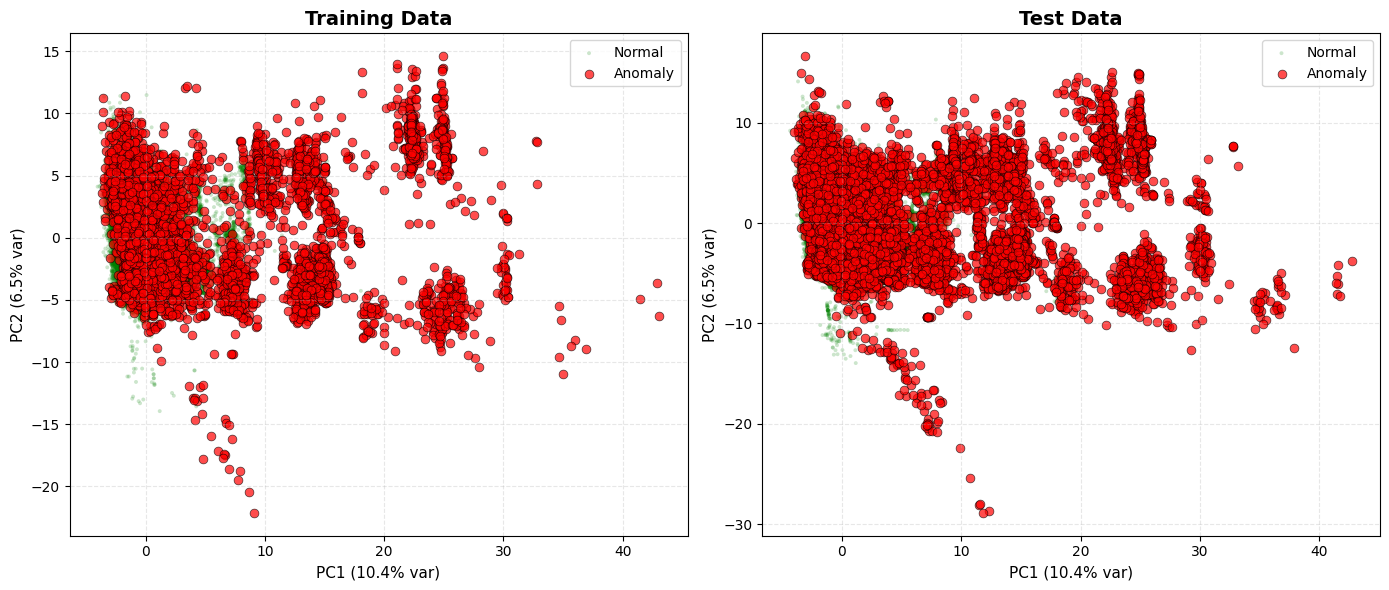

In [ ]:
# Summary Statistics
print("="*80)
print("ISOLATION FOREST - SUMMARY STATISTICS")
print("="*80)

print(f"\nPREDICTION DISTRIBUTION (Test Set)")
print("-"*80)
normal_count = (y_pred_test == 1).sum()
anomaly_count = (y_pred_test == -1).sum()
print(f"Normal      : {normal_count:6,} ({normal_count/len(y_pred_test)*100:5.2f}%)")
print(f"Anomalies   : {anomaly_count:6,} ({anomaly_count/len(y_pred_test)*100:5.2f}%)")

print(f"\nDECISION SCORES")
print("-"*80)
print(f"Overall Statistics:")
print(f"  Mean  : {decision_scores_test.mean():8.4f}")
print(f"  Median: {np.median(decision_scores_test):8.4f}")
print(f"  Std   : {decision_scores_test.std():8.4f}")
print(f"  Min   : {decision_scores_test.min():8.4f}")
print(f"  Max   : {decision_scores_test.max():8.4f}")

print(f"\nBy Prediction:")
print(f"  Normal Transactions:")
print(f"    Mean Score: {decision_scores_test[normal_mask].mean():8.4f}")
print(f"    Std Score : {decision_scores_test[normal_mask].std():8.4f}")
print(f"  Anomalous Transactions:")
print(f"    Mean Score: {decision_scores_test[anomaly_mask].mean():8.4f}")
print(f"    Std Score : {decision_scores_test[anomaly_mask].std():8.4f}")

print(f"\nBy True Label:")
for label in ['licit', 'illicit', 'unknown']:
    if label in y_test.values:
        mask = y_test == label
        print(f"  {label.capitalize():12s}: Mean = {decision_scores_test[mask].mean():8.4f}, Std = {decision_scores_test[mask].std():8.4f}")

# Performance on Illicit Transactions
if 'illicit' in y_test.values:
    print(f"\nILLICIT TRANSACTION DETECTION")
    print("-"*80)
    illicit_mask = y_test == 'illicit'
    illicit_total = illicit_mask.sum()
    illicit_flagged = ((y_test == 'illicit') & (y_pred_test == -1)).sum()
    illicit_recall = (illicit_flagged / illicit_total) * 100 if illicit_total > 0 else 0
    
    print(f"Total Illicit Transactions: {illicit_total:,}")
    print(f"Illicit Flagged as Anomalies: {illicit_flagged:,} ({illicit_recall:.2f}%)")
    print(f"Illicit Missed (False Negatives): {illicit_total - illicit_flagged:,} ({100-illicit_recall:.2f}%)")

# Performance on Licit Transactions
if 'licit' in y_test.values:
    print(f"\nLICIT TRANSACTION DETECTION")
    print("-"*80)
    licit_mask = y_test == 'licit'
    licit_total = licit_mask.sum()
    licit_correct = ((y_test == 'licit') & (y_pred_test == 1)).sum()
    licit_accuracy = (licit_correct / licit_total) * 100 if licit_total > 0 else 0
    
    print(f"Total Licit Transactions: {licit_total:,}")
    print(f"Licit Correctly Classified: {licit_correct:,} ({licit_accuracy:.2f}%)")
    print(f"Licit Misclassified as Anomalies: {licit_total - licit_correct:,} ({100-licit_accuracy:.2f}%)")

print("\n" + "="*80)

# Visualize decision score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution by True Label
for label, color in label_map.items():
    if label in y_test.values:
        mask = y_test == label
        axes[0].hist(decision_scores_test[mask], bins=50, alpha=0.5, 
                    color=color, label=label.capitalize(), density=True)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Decision Function Score', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Anomaly Score Distribution by True Label', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution by Prediction
axes[1].hist(decision_scores_test[normal_mask], bins=50, alpha=0.6, 
            color='green', label='Predicted Normal', density=True)
axes[1].hist(decision_scores_test[anomaly_mask], bins=50, alpha=0.6, 
            color='red', label='Predicted Anomaly', density=True)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_xlabel('Decision Function Score', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Anomaly Score Distribution by Prediction', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for box plot
box_data = []
box_labels = []
box_colors = []

for label in ['licit', 'illicit', 'unknown']:
    if label in y_test.values:
        mask = y_test == label
        box_data.append(decision_scores_test[mask])
        box_labels.append(label.capitalize())
        box_colors.append(label_map[label])

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax.set_ylabel('Decision Function Score', fontsize=12)
ax.set_title('Anomaly Score Distribution by True Label', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.show()